1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [51]:
import pandas as pd
%matplotlib inline

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [52]:
df = df.replace(['Yes'], 1).replace(['No'], 0) 
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

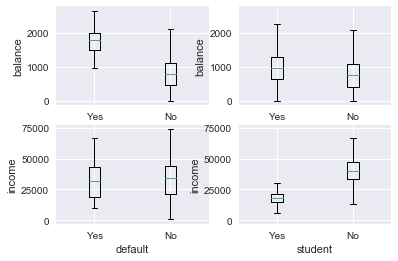

In [53]:
import seaborn
from matplotlib import pylab as plt

f, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2)
plot1.boxplot([df.balance[df.default == 1], df.balance[df.default == 0]])
plot1.set_xticklabels(('Yes', 'No'))
plot1.set_xlabel('default')
plot1.set_ylabel('balance')

plot2.boxplot([df.balance[df.student == 1], df.balance[df.student == 0]])
plot2.set_xticklabels(('Yes', 'No'))
plot2.set_xlabel('student')
plot2.set_ylabel('balance')

plot3.boxplot([df.income[df.default == 1], df.income[df.default == 0]])
plot3.set_xticklabels(('Yes', 'No'))
plot3.set_xlabel('default')
plot3.set_ylabel('income')

plot4.boxplot([df.income[df.student == 1], df.income[df.student == 0]])
plot4.set_xticklabels(('Yes', 'No'))
plot4.set_xlabel('student')
plot4.set_ylabel('income')

plt.show()


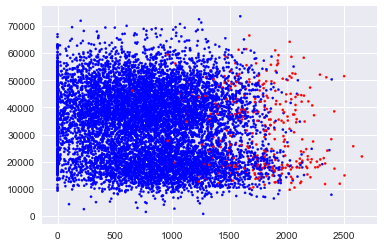

In [54]:
plt.scatter(df.balance, df.income,
            c = df.copy(deep = True).default.replace([1], 'red').replace([0], 'blue'), 
            marker = 'o',
            s = 5)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

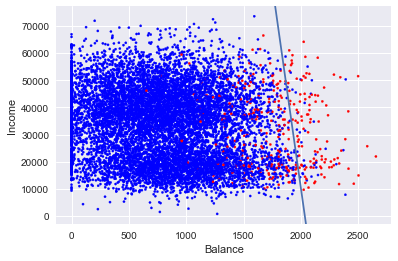

Area under the ROC curve :  0.96050521251


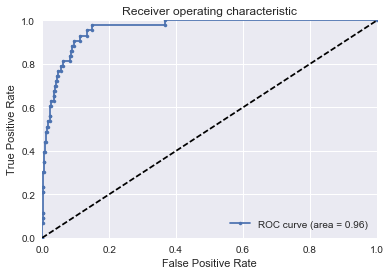

In [55]:
# code referece (http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

y = df.default
X = df.drop(['default', 'student'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)

plt.scatter(df.balance, df.income,
            c = df.copy(deep = True).default.replace([1], 'red').replace([0], 'blue'), 
            marker = 'o',
            s = 5)

b = logreg.intercept_
w = logreg.coef_[0]

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

x = np.arange(xmin, xmax, 1)
y = (b + w[0] * x) / -w[1]

plt.plot(x, y)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Balance')
plt.ylabel('Income')


plt.show()

y = df.default
X = df.drop(['default', 'student'], 1)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

{'C': 1e-10, 'penalty': 'l2'}
coeff values:  [ -2.19425792e-08   3.32386360e-06  -1.05374731e-04]


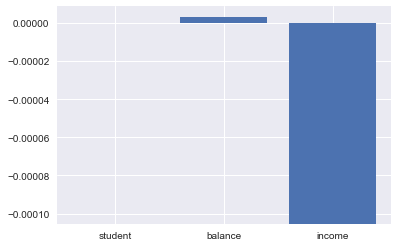

Area under the ROC curve :  0.543919692977


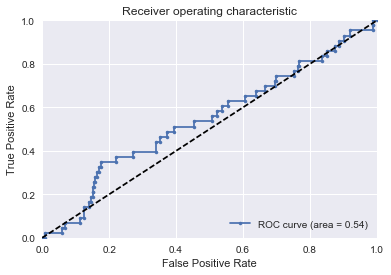

In [68]:
from sklearn.grid_search import GridSearchCV 

y = df.default
X = df.drop(['default'], 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

# using GridSearchCV to find the optimal C for logistic regression with penalty l2/ridge
logreg = LogisticRegression()
params = {'C': np.logspace(-10,5,100), 'penalty' : ['l2']}
clf = GridSearchCV(logreg, params, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_params_)

logreg = LogisticRegression(C = clf.best_params_['C'], penalty = 'l2')
logreg.fit(X_train, y_train)

index = np.arange(len(logreg.coef_[0]))

plt.bar(index, logreg.coef_[0])
plt.xticks(index, ("student", "balance", "income"))
print("coeff values: ", logreg.coef_[0])

plt.show()


# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=clf.best_params_['C'],penalty='l2')

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)



6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

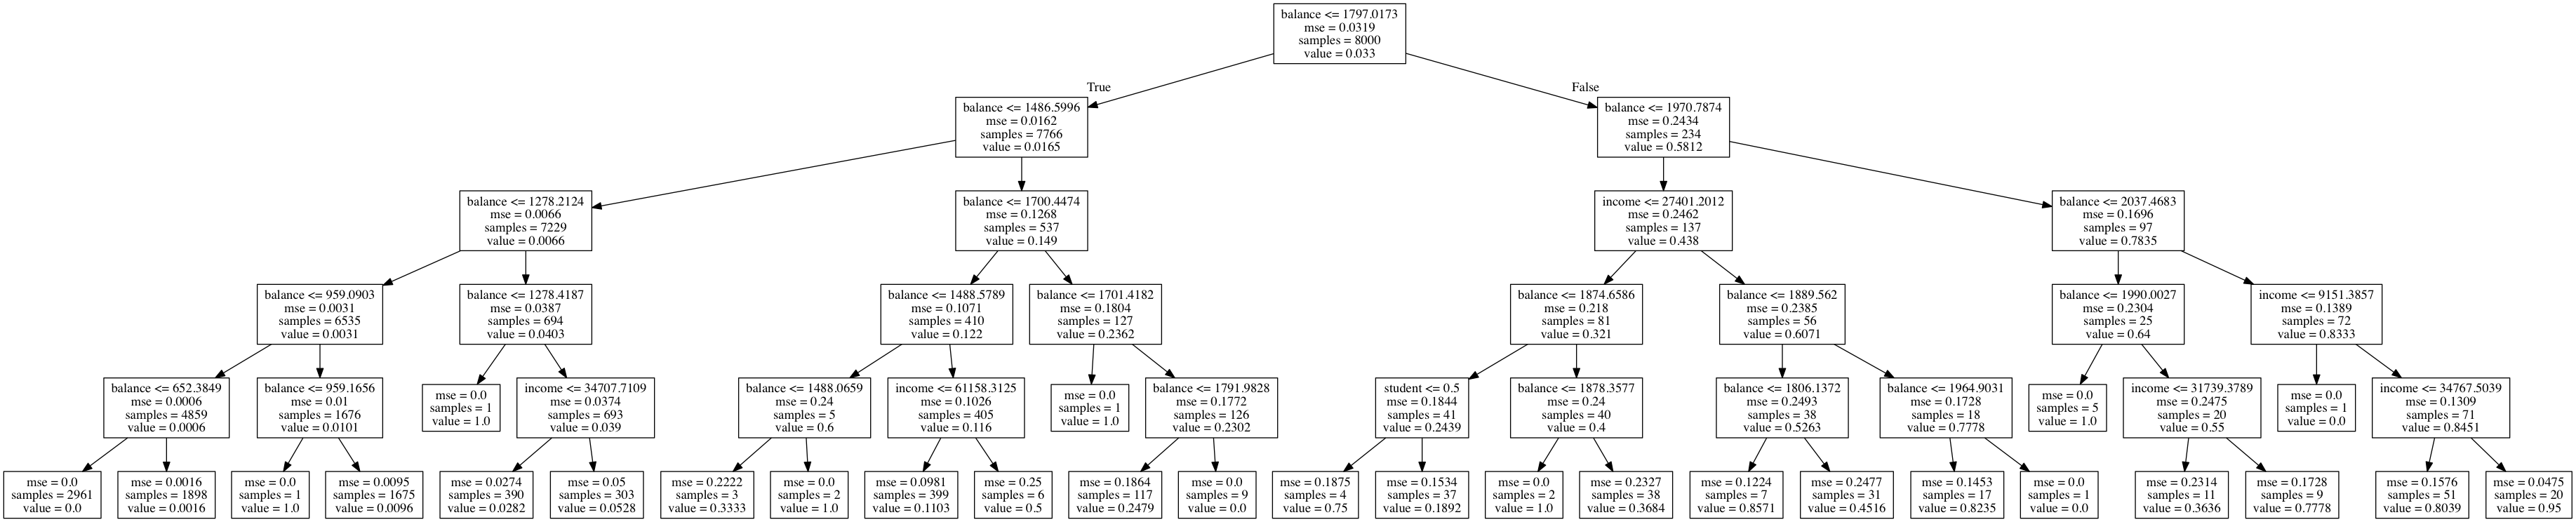

In [161]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

dt=DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

8) Find the optimal decision tree depth and compute the AUC ROC. 

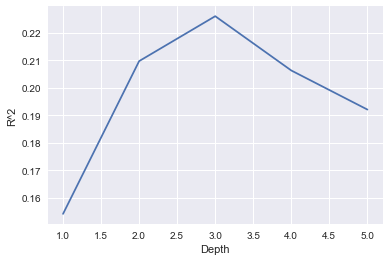

In [162]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

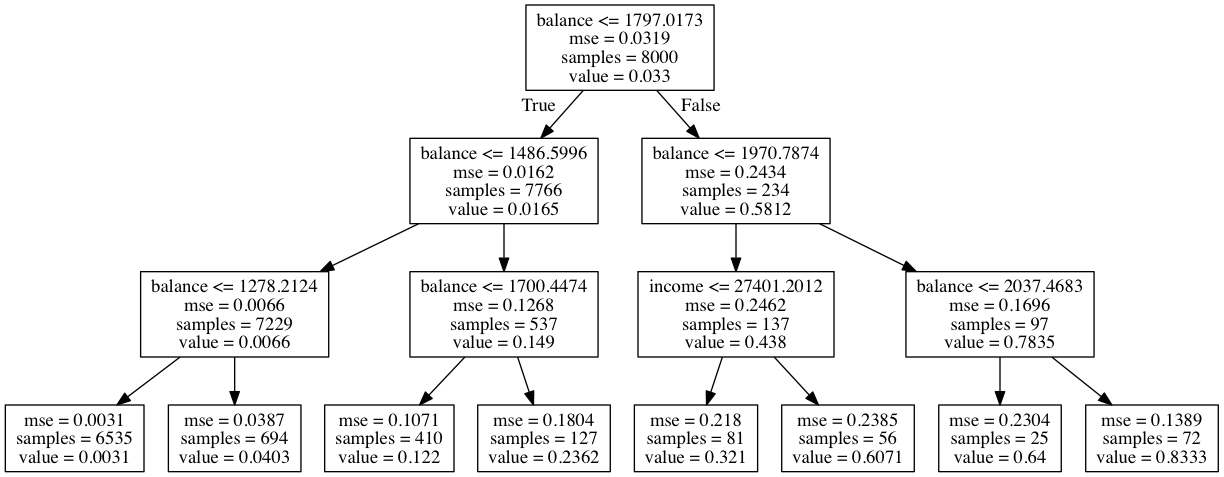

In [164]:
dt=DecisionTreeRegressor(max_depth=n_opt)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 